#  Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Нужно построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
•	качество предсказания;
•	время обучения модели;
•	время предсказания модели.


## Шаг 1. Общий обзор данных

In [1]:
import pandas as pd #подключаем необходимые библиотеки
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

In [2]:
try:
    df = pd.read_csv('D:\datasets\аutos.csv', sep = ',') #записываем данные из файла в переменную df
except:
    df = pd.read_csv('/datasets/autos.csv', sep = ',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 столбцов, целевой признак - Price(цена), пропуски в данных присутствуют

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбце с ценой есть нули - такие объявления можно считать вбросами и не учитывать при обучении, также стоит обратить внимание на слишком дешевые машины.<br> В столбце с датой регистрации есть очевидные вбросы(9999 и 1000 год)<br>В столбце с мощностью автомобилей также нужно будет удалить аномальные значения<br>Столбцы с месяцем регистрации, количеством фото и почтовым индексом мы использовать не будем.

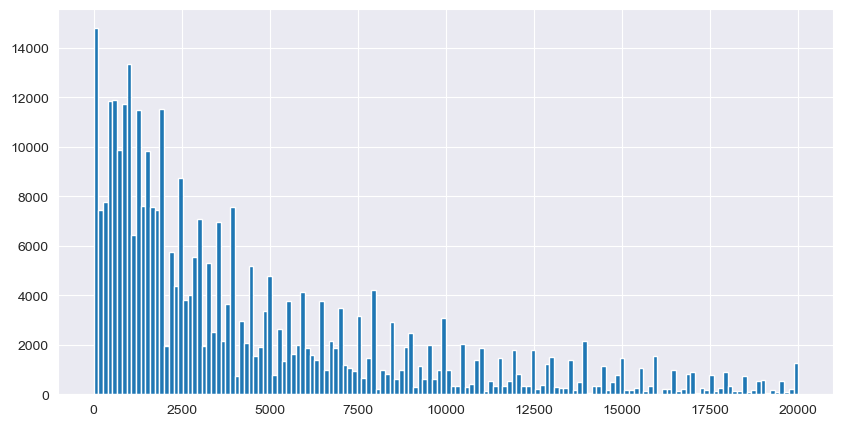

In [6]:
df.Price.hist(bins=150, figsize=(10,5));# распределение цен на автомобили

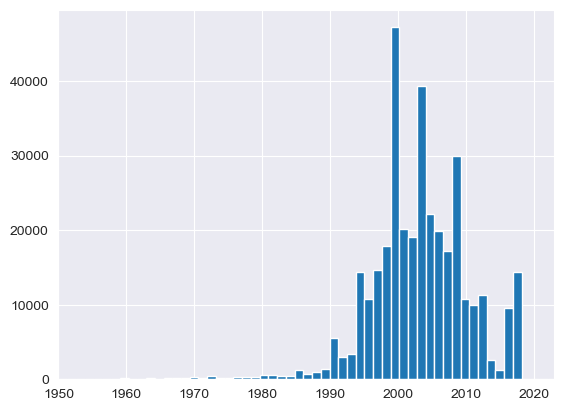

In [7]:
x = df.RegistrationYear# гистограмма с распределением по годам регистрации
plt.hist(x, 7000, histtype ='bar')
plt.xlim(1950, 2023)
plt.show()

Больше всего автомобилей были зарегистрированы около 2000 года, также присутствуют очень старые автомобили(старше 1980 года)

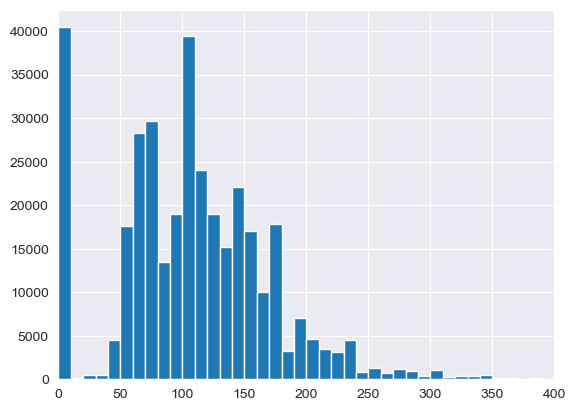

In [8]:
x = df.Power# распределение по мощности автомобилей
plt.hist(x, 2000, histtype ='bar')
plt.xlim(0, 400)
plt.show()

Очень большое количество значений около нуля

In [9]:
df.Kilometer.value_counts()# значения пробега в данных

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

Похоже на то, что пробег в анкете округляется, очевидных вбросов в данных нет

Удалим ненужные признаки из данных и проверим корреляции между признаками

In [10]:
df = df.drop_duplicates()# удалим полные дубликаты до создания датафрейма с нужными признаками

In [11]:
df_updated = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
                      'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
                      'Repaired']]# оставляем только нужные признаки

Мы удалили столбцы, связанные с действиями с объявлением и данными пользователя, они никак не влияют на цену - 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'DateCrawled'<br>Также были удалены данные о месяце регистрации авто, года будет достаточно.

In [12]:
df_updated.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


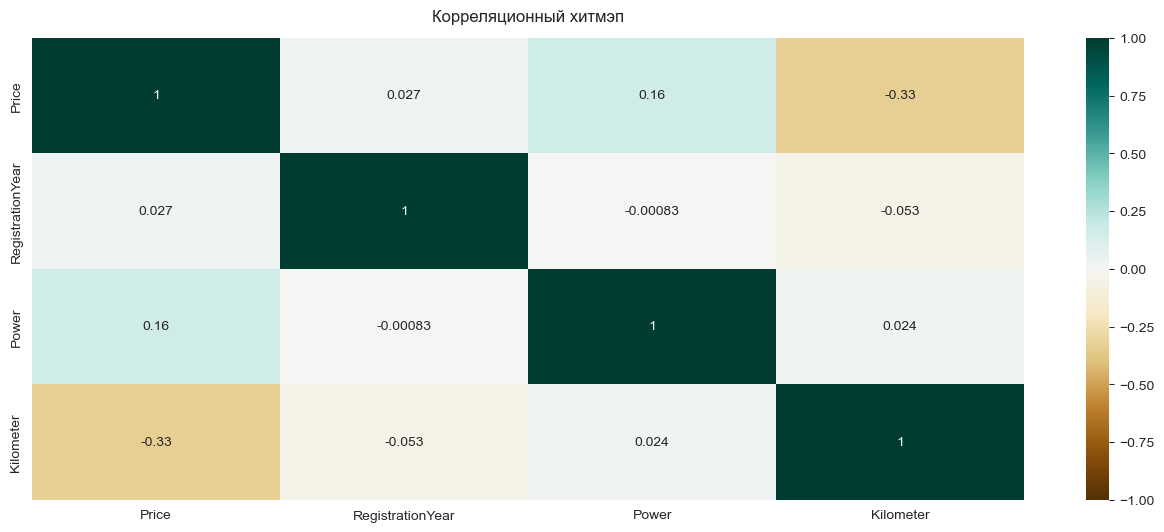

In [13]:
plt.figure(figsize=(16, 6))# тепловая карта корреляций
heatmap = sns.heatmap(df_updated.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционный хитмэп', fontdict={'fontsize':12}, pad=12);

Мультиколлинеарности между численными признаками не обнаружено

## Шаг 2. Подготовка данных

### Удаление дубликатов

Проверим неочевидные дубликаты в категориальных признаках

In [14]:
df_updated.VehicleType.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [15]:
df_updated.Gearbox.value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [16]:
df_updated.Model.value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [17]:
df_updated.FuelType.value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [18]:
df_updated.Brand.value_counts()

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2322
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

Неочевидных дубликатов нет

### Преобразование типов даных

Преобразуем тип в колонке repaired с текста на 1 и 0

In [19]:
df_updated.Repaired.value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

In [20]:
df_updated = df_updated.replace({'yes': 1, 'no': 0})

### Обработка пропусков

In [21]:
df_updated.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Удалить пропуски не получится, так как таких значений слишком много и потеряем значительную часть данных.<br> Категориальные данные можно заменить на данные из похожих строк, например:<br>-у одинаковых моделей автомобилей можно подставить такой же тип кузова в пропущенное значение<br>-у типов коробки передач можно подставить самое частое значение у таких же моделей<br>-пропуски в моделях можно восстановить по другим строкам с большим количеством совпадений категориальных признаков<br>-вид топлива подставить по самому частому значению у модели<br>-с ремонтом сложнее, так как этот признак не зависит от других в столбце, можно проверить по медианной цене внутри модели

Модель

In [22]:
# заменяем пропущенные значения в модели на самую частую комбинацию бренда и мощности двигателя из других столбцов 
df_updated.loc[:, 'Model'] = df_updated.groupby(['Brand', 'Power'])['Model']\
    .transform(lambda x: x.mode().values[0] if not x.isnull().all() else np.nan)

In [23]:
df_updated.Model.isna().sum()

3574

Оставшиеся пропуски можно удалить из датасета

In [24]:
df_updated = df_updated.dropna(subset=['Model'])

In [25]:
df_updated.Model.isna().sum()

0

Тип кузова

In [26]:
# функция будет менять пропущенное значение на самое частое у такой же модели
def replacer(column):
    return df_updated.groupby('Model')[column]\
        .transform(lambda x: x.mode().values[0] if not x.isnull().all() else np.nan)

In [27]:
df_updated.loc[:, 'VehicleType'] = replacer('VehicleType')

In [28]:
df_updated.VehicleType.isna().sum()

0

Тип коробки передач

In [29]:
df_updated.loc[:, 'Gearbox'] = replacer('Gearbox')

In [30]:
df_updated.Gearbox.isna().sum()

0

Тип топлива

In [31]:
df_updated.loc[:, 'FuelType'] = replacer('FuelType')

In [32]:
df_updated.FuelType.isna().sum()

0

Ремонт

Если цена автомобиля из строки с пропущенным значением по ремонту меньше медианной по модели, то подставим значение True и наоборот

In [33]:
frequent_types_median = df_updated.groupby('Model')['Price'].median()# посчитаем медиану цены по каждой из моделей
def repair_replacer(row):# функция заменяет пропуски на 1 или 0 в зависимости от отношения к медианной цене модели
    if pd.isna(row['Repaired']):
        if row['Model'] in frequent_types_median:
            if row['Price'] > frequent_types_median[row['Model']]:
                return False
            else:
                return True
        else:
            return row['Repaired']
    else:
        return row['Repaired']

df_updated.loc[:, 'Repaired'] = df_updated.apply(repair_replacer, axis=1)# применим функцию к датафрейму

In [34]:
df_updated.Repaired.isna().sum()

0

In [35]:
df_updated.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [36]:
df_updated.shape

(350791, 10)

Все пропуски обработаны, потеряно незначительное количество строк

### Аномальные значения

Год регистрации

In [37]:
df_updated.shape

(350791, 10)

In [38]:
df_updated.RegistrationYear.value_counts()

2000    24074
1999    22640
2005    21901
2001    20034
2006    19787
        ...  
2900        1
1940        1
1949        1
2066        1
1600        1
Name: RegistrationYear, Length: 134, dtype: int64

Будем учитывать дату регистрации от 1960 до 2016 включительно

In [39]:
df_updated = df_updated[(df_updated['RegistrationYear'] >= 1960) & (df_updated['RegistrationYear'] <= 2016)]

In [40]:
df_updated.shape

(336174, 10)

Цена

In [41]:
df_updated.Price.value_counts()

0        9476
500      5411
1500     5051
1000     4296
1200     4295
         ... 
6235        1
1379        1
5377        1
3021        1
10985       1
Name: Price, Length: 3676, dtype: int64

Большое количество значений цены равно нулю, заменим их по совпадению модели и года регистрации

In [42]:
# создаем словарь с комбинацией модели и года выпуска и определяем цену для нее
price_mapping = df_updated[df_updated['Price']>100].groupby(['Model', 'RegistrationYear'])['Price']\
    .apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None).to_dict()

# заменяем нули в цене на подходящую комбинацию модели и года из других столбцов
df_updated['Price'] = df_updated.apply(lambda row: price_mapping[(row['Model'], row['RegistrationYear'])] if row['Price'] == 0 and (row['Model'], row['RegistrationYear'])
                                                                                                             in price_mapping else row['Price'], axis=1)

Удалим из данных машины дешевле 100 евро, можно считать такие объявления продажей 'металлолома' и не учитывать для обучения

In [43]:
df_updated = df_updated[df_updated['Price'] >= 100]

In [44]:
df_updated.shape

(333829, 10)

Мощность

In [45]:
df_updated.Power.value_counts()

0       33929
75      22620
60      15026
150     14047
101     12680
        ...  
6018        1
751         1
612         1
1506        1
3           1
Name: Power, Length: 668, dtype: int64

В датасете очень много значений с нулем, подменим данными из строчек с идентичной моделью и годом выпуска

In [46]:
# создаем словарь с комбинацией модели и года выпуска и определяем цену для нее
power_mapping = df_updated[(df_updated['Power'] >= 26) 
                           & (df_updated['Power'] <= 1000)].groupby(['Model', 'RegistrationYear'])['Power']\
    .apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None).to_dict()

# заменяем нули в мощности на подходящую комбинацию модели и года из других столбцов
df_updated['Power'] = df_updated.apply(lambda row: power_mapping[(row['Model'], row['RegistrationYear'])] 
if row['Power'] == 0 and (row['Model'], row['RegistrationYear']) in power_mapping else row['Power'], axis=1)

In [47]:
df_updated.shape

(333829, 10)

Возьмем 26 л.с. за минимальный порог и 1000 как максимальный(болид формулы 1)

In [48]:
df_updated = df_updated[(df_updated['Power'] >= 26) & (df_updated['Power'] <= 1000)]

In [49]:
df_updated.shape

(332988, 10)

## Шаг 3. Подготовка признаков


Мы будем обучать две модели бустинга LightGBM и Catboost, а также случайный лес.

В дальнейшем нам нужно будет перекодировать категориальные признаки для обучения случайного леса, перед этим нужно удалить наименее представленные в этих столбцах категории

In [50]:
df_updated.VehicleType.value_counts()

sedan          163016
small           90497
wagon           55405
bus             14524
suv              5171
coupe            2826
convertible      1546
other               3
Name: VehicleType, dtype: int64

Удалим категорию other

In [51]:
df_updated.Model.value_counts().tail(101)

300c          199
ducato        192
escort        186
captiva       183
auris         181
             ... 
kalina          2
citigo          2
roomster        2
elefantino      2
cc              1
Name: Model, Length: 101, dtype: int64

Удалим категории, где менее 200 вхождений

In [52]:
df_updated.FuelType.value_counts()

petrol      278064
gasoline     54739
cng            177
lpg              8
Name: FuelType, dtype: int64

Удалим категорию lpg

In [53]:
df_updated['Model'].value_counts().tail(101).index

Index(['300c', 'ducato', 'escort', 'captiva', 'auris', 'c4', 'forester',
       'caddy', 'c_reihe', 'x_type',
       ...
       'calibra', 'beetle', 'serie_2', 'crossfire', 'range_rover_evoque',
       'kalina', 'citigo', 'roomster', 'elefantino', 'cc'],
      dtype='object', length=101)

In [54]:
df_updated = df_updated.query('VehicleType != "other"')
df_updated = df_updated.query('FuelType != "lpg"')

#удаляем из датафрейма категории моделей с менее чем 200 вхождениями
models_to_remove = df_updated['Model'].value_counts().tail(101).index
df_updated = df_updated[~df_updated['Model'].isin(models_to_remove)]

Выделим признаки

In [55]:
features = df_updated.drop(['Price'], axis=1)
target = df_updated['Price']

In [56]:
# Преобразование столбцов в целочисленный формат
features['Gearbox'] = features['Gearbox'].replace({'manual':0, 'auto':1})
features['Repaired'] = features['Repaired'].astype(int)
features['Gearbox'] = features['Gearbox'].astype(int)

Теперь разделим весь датасет на выборки - обучающую валидационную и тестовую в соотношении 3:1:1

In [57]:
# для начала выделим обучающую выборку 
features_train, features_other, target_train, target_other = \
    train_test_split(features, target, test_size=0.4, random_state=12345)

# разделим 40% датасета на валидационную и тестовую выборки 
features_valid, features_test, target_valid, target_test = \
    train_test_split(features_other, target_other, test_size=0.5, random_state=12345)

In [58]:
# масштабируем признаки
scaler = StandardScaler()
columns_to_scale = ['RegistrationYear', 'Power', 'Kilometer']

scaled_columns_train = scaler.fit_transform(features_train[columns_to_scale].values)
scaled_columns_valid = scaler.transform(features_valid[columns_to_scale].values)
scaled_columns_test = scaler.transform(features_test[columns_to_scale].values)

features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()

features_train[columns_to_scale] = scaled_columns_train
features_valid[columns_to_scale] = scaled_columns_valid
features_test[columns_to_scale] = scaled_columns_test

Для обучения случайного леса преобразуем категориальные признаки с помощью OHE и бинарного кодирования

In [59]:
enc = OneHotEncoder(drop='first')
columns_to_ohe = ['VehicleType', 'Model', 'FuelType', 'Brand']
features_train_encoded = enc.fit_transform(features_train[columns_to_ohe])
features_valid_encoded = enc.transform(features_valid[columns_to_ohe])
features_test_encoded = enc.transform(features_test[columns_to_ohe])

features_train_array = features_train_encoded.toarray()
features_valid_array = features_valid_encoded.toarray()
features_test_array = features_test_encoded.toarray()

# Создание нового датафрейма с закодированными признаками
encoded_features_train_df = pd.DataFrame(features_train_array, 
                                         columns=enc.get_feature_names_out(columns_to_ohe),
                                         index=features_train.index)
encoded_features_valid_df = pd.DataFrame(features_valid_array, 
                                         columns=enc.get_feature_names_out(columns_to_ohe),
                                         index=features_valid.index)
encoded_features_df_test = pd.DataFrame(features_test_array, 
                                        columns=enc.get_feature_names_out(columns_to_ohe),
                                        index=features_test.index)

# объединим признаки и результат кодирования и удалим ненужные столбцы
features_train_forest = features_train.join(encoded_features_train_df).drop(columns = columns_to_ohe, axis= 1)
features_valid_forest = features_valid.join(encoded_features_valid_df).drop(columns = columns_to_ohe, axis= 1)
features_test_forest = features_test.join(encoded_features_df_test).drop(columns = columns_to_ohe, axis= 1)

Признаки для случайного леса

In [60]:
print('Размеры тренировочных выборок:', features_train_forest.shape, target_train.shape)

Размеры тренировочных выборок: (194878, 168) (194878,)


In [61]:
print('Размеры валидационных выборок:', features_valid_forest.shape, target_valid.shape)

Размеры валидационных выборок: (64960, 168) (64960,)


In [62]:
print('Размеры тестовых выборок:', features_test_forest.shape, target_test.shape)

Размеры тестовых выборок: (64960, 168) (64960,)


Признаки для бустинга

In [63]:
print('Размеры тренировочных выборок:', features_train.shape, target_train.shape)

Размеры тренировочных выборок: (194878, 9) (194878,)


In [64]:
print('Размеры валидационных выборок:', features_valid.shape, target_valid.shape)

Размеры валидационных выборок: (64960, 9) (64960,)


In [65]:
print('Размеры тестовых выборок:', features_test.shape, target_test.shape)

Размеры тестовых выборок: (64960, 9) (64960,)


# Шаг 4. Обучение моделей

## Случайный лес

Для подбора параметров используем RandomizedSearchCV, а не GridSearchCV, так как после преобразования у нас получилось очень много признаков, что может сильно сказаться на скорости подбора.

In [66]:
%%time
forest = RandomForestRegressor(random_state=12345)
param_dist = {"max_depth": [8], 'n_estimators': [120, 180]}# распределение параметров для подбора
rsc = RandomizedSearchCV(forest, param_dist, cv=2, n_iter=2, scoring='neg_mean_squared_error')#используем RandomizedSearchCV для подбора параметров
search_f = rsc.fit(features_train_forest, target_train)
print(f'Лучшие параметры для леса: {search_f.best_params_}')
print(f'Лучшее значение метрики: {np.sqrt(abs(search_f.best_score_))}')

Лучшие параметры для леса: {'n_estimators': 180, 'max_depth': 8}
Лучшее значение метрики: 2023.135928775542
Wall time: 10min 1s


In [67]:
%%time
model_f = RandomForestRegressor(max_depth=search_f.best_params_['max_depth'], n_estimators=search_f.best_params_['n_estimators'], random_state=12345)# задаем модель и считаем оценку кросс-валидации
final_scores_f = np.sqrt(abs(cross_val_score(model_f, features_train_forest, target_train, cv=2, scoring='neg_mean_squared_error').mean()))
print(f'Оценка кросс-валидации случайного леса: {final_scores_f}')

Оценка кросс-валидации случайного леса: 2023.135928775542
Wall time: 3min 32s


In [68]:
%time model_f.fit(features_train_forest, target_train)# обучаем модель
%time model_f.predict(features_valid_forest)
forest_predictions = model_f.predict(features_valid_forest) # получаем предсказания на валидационной выборке
print(f'Оценка RMSE на валидационной выборке: {mean_squared_error(target_valid, forest_predictions, squared=False)}')

Wall time: 3min 47s
Wall time: 930 ms
Оценка RMSE на валидационной выборке: 2030.4629432720017


Модель показывает результат методики лучше порога(2500) по кросс-валидации и проверке на валидационной выборке, время подбора параметров, обучения и предсказание нужно сравнить с остальными моделями. Низкая скорость обучения делает подбор параметров слишком медленным.

## CatBoost

In [69]:
%%time
param_grid = {
    'iterations': [350, 500],
    'depth': [5, 8],
    'learning_rate': [0.03]
}# распределение параметров для подбора
cat = CatBoostRegressor(random_state=12345, cat_features=columns_to_ohe)
crscv = RandomizedSearchCV(cat, param_grid, cv=2, n_iter=4, scoring='neg_mean_squared_error')# Используем RandomizedSearchCV для перебора по сетке и подбора параметров
cat_search = crscv.fit(features_train, target_train)

print("Лучшие параметры: ", cat_search.best_params_)
print("Лучшее значение метрики: ", np.sqrt(abs(cat_search.best_score_)))

C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 4389.8169401	total: 181ms	remaining: 1m 3s
1:	learn: 4309.6355597	total: 224ms	remaining: 38.9s
2:	learn: 4232.7080256	total: 258ms	remaining: 29.8s
3:	learn: 4157.4044859	total: 292ms	remaining: 25.3s
4:	learn: 4086.3116658	total: 330ms	remaining: 22.8s
5:	learn: 4016.8589503	total: 361ms	remaining: 20.7s
6:	learn: 3950.7437107	total: 393ms	remaining: 19.3s
7:	learn: 3883.7509823	total: 428ms	remaining: 18.3s
8:	learn: 3819.3933728	total: 465ms	remaining: 17.6s
9:	learn: 3756.3546250	total: 508ms	remaining: 17.3s
10:	learn: 3695.8108326	total: 546ms	remaining: 16.8s
11:	learn: 3637.8389015	total: 583ms	remaining: 16.4s
12:	learn: 3581.4009829	total: 625ms	remaining: 16.2s
13:	learn: 3527.5698995	total: 662ms	remaining: 15.9s
14:	learn: 3476.9304579	total: 700ms	remaining: 15.6s
15:	learn: 3425.1103511	total: 748ms	remaining: 15.6s
16:	learn: 3375.4841293	total: 790ms	remaining: 15.5s
17:	learn: 3328.9089615	total: 839ms	remaining: 15.5s
18:	learn: 3283.6930835	total: 882ms	r

In [70]:
%%time
model_cat = CatBoostRegressor(iterations=cat_search.best_params_['iterations'], learning_rate=cat_search.best_params_['learning_rate'], depth=cat_search.best_params_['depth'], cat_features=columns_to_ohe, random_state=12345)
# задаем подобранные параметры для модели
params = {
    'learning_rate': cat_search.best_params_['learning_rate'],
    'depth': cat_search.best_params_['depth'],
    'iterations': cat_search.best_params_['iterations'],
    'loss_function': 'RMSE', # метрика для кросс-валидации
}
train_pool = Pool(data=features_train, label=target_train, cat_features=columns_to_ohe)# создаем обеъкт pool из df
cv_data = cv(
    pool=train_pool,  # обучающие данные
    params=params,
    iterations=cat_search.best_params_['iterations'],  # количество итераций в каждом фолде
    early_stopping_rounds=10, # остановить обучение, если метрика не улучшается в течение указанного количества итераций
    fold_count=3, # кол-во фолдов
)

Training on fold [0/3]
0:	learn: 6212.9571616	test: 6182.1440827	best: 6182.1440827 (0)	total: 108ms	remaining: 54s
1:	learn: 6056.5375253	test: 6027.0840932	best: 6027.0840932 (1)	total: 209ms	remaining: 52.1s
2:	learn: 5906.5929394	test: 5877.4662881	best: 5877.4662881 (2)	total: 299ms	remaining: 49.6s
3:	learn: 5760.5394350	test: 5732.0671920	best: 5732.0671920 (3)	total: 394ms	remaining: 48.9s
4:	learn: 5620.6970118	test: 5592.8605782	best: 5592.8605782 (4)	total: 485ms	remaining: 48s
5:	learn: 5483.3716117	test: 5456.2835213	best: 5456.2835213 (5)	total: 577ms	remaining: 47.5s
6:	learn: 5352.7806239	test: 5325.9167413	best: 5325.9167413 (6)	total: 663ms	remaining: 46.7s
7:	learn: 5224.9368249	test: 5198.4735085	best: 5198.4735085 (7)	total: 756ms	remaining: 46.5s
8:	learn: 5101.3172052	test: 5075.6243927	best: 5075.6243927 (8)	total: 853ms	remaining: 46.5s
9:	learn: 4982.7586136	test: 4957.7965046	best: 4957.7965046 (9)	total: 942ms	remaining: 46.1s
10:	learn: 4866.9855226	test: 4

In [71]:
%time model_cat.fit(features_train, target_train)
%time model_cat.predict(features_valid)
cat_pred = model_cat.predict(features_valid)
print(f'Оценка RMSE на валидационной выборке: {mean_squared_error(target_valid, cat_pred, squared=False)}')

0:	learn: 4385.8096913	total: 106ms	remaining: 53s
1:	learn: 4294.7534801	total: 218ms	remaining: 54.3s
2:	learn: 4207.3421488	total: 304ms	remaining: 50.3s
3:	learn: 4122.4978955	total: 416ms	remaining: 51.6s
4:	learn: 4040.1971783	total: 516ms	remaining: 51.1s
5:	learn: 3961.7896177	total: 616ms	remaining: 50.7s
6:	learn: 3886.1988680	total: 722ms	remaining: 50.8s
7:	learn: 3813.7865789	total: 828ms	remaining: 50.9s
8:	learn: 3742.7531721	total: 927ms	remaining: 50.6s
9:	learn: 3673.3430745	total: 1.02s	remaining: 50.1s
10:	learn: 3609.1486084	total: 1.12s	remaining: 49.9s
11:	learn: 3543.9558819	total: 1.22s	remaining: 49.7s
12:	learn: 3483.3632308	total: 1.31s	remaining: 49.2s
13:	learn: 3424.7563878	total: 1.41s	remaining: 49.1s
14:	learn: 3367.6144609	total: 1.53s	remaining: 49.3s
15:	learn: 3311.7180984	total: 1.63s	remaining: 49.3s
16:	learn: 3258.8118991	total: 1.73s	remaining: 49.1s
17:	learn: 3207.0691128	total: 1.82s	remaining: 48.6s
18:	learn: 3157.1379976	total: 1.92s	rem

Все операции для модели проходят намного быстрее, метрика тоже значительно выросла. Улучшенное время получается из-за скорости обучения и того, что не нужно кодировать категориальные признаки.

## LightGBM

Категориальные признаки нужно сначала перекодировать в category, чтобы их мог обработать LightGBM, так как он работает только с int

In [72]:
features_train_gbm, features_valid_gbm, features_test_gbm = features_train.copy(), features_valid.copy(), features_test.copy()
features_train_gbm[columns_to_ohe] = features_train_gbm[columns_to_ohe].astype('category')
features_valid_gbm[columns_to_ohe] = features_valid_gbm[columns_to_ohe].astype('category')
features_test_gbm[columns_to_ohe] = features_test_gbm[columns_to_ohe].astype('category')

In [73]:
%%time
param_gbm = {
    'n_estimators': [150, 300, 500],
    'num_leaves': [60, 65, 70],
    'max_depth': [3, 6, 10]
}# распределение параметров для подбора

train_data = lgb.Dataset(data=features_train_gbm, label=target_train, categorical_feature=columns_to_ohe) #хранилище для признаков
valid_data = lgb.Dataset(data=features_valid_gbm, label=target_valid, categorical_feature=columns_to_ohe)
test_data = lgb.Dataset(data=features_test_gbm, label=target_test, categorical_feature=columns_to_ohe)

gbm = lgb.LGBMRegressor(random_state=12345)
grscv = RandomizedSearchCV(gbm, param_gbm, cv=3, n_iter=10, scoring='neg_mean_squared_error')
gbm_search = grscv.fit(train_data.data, train_data.label)# используем перекодированные признаки для подбора параметров

print("Лучшие параметры:", gbm_search.best_params_)
print("Лучшее значение метрики: ", np.sqrt(abs(gbm_search.best_score_)))

Лучшие параметры: {'num_leaves': 60, 'n_estimators': 300, 'max_depth': 10}
Лучшее значение метрики:  1739.5033111713642
Wall time: 33.6 s


In [74]:
%%time
model_gbm = lgb.LGBMRegressor(num_leaves=gbm_search.best_params_['num_leaves'], n_estimators=gbm_search.best_params_['n_estimators'], max_depth=gbm_search.best_params_['max_depth'], random_state=12345)
gbm_scores = np.sqrt(abs(cross_val_score(model_gbm, train_data.data, train_data.label, cv=5, scoring='neg_mean_squared_error').mean()))
print(f'Оценка кросс-валидации LightGBM: {gbm_scores}')

Оценка кросс-валидации LightGBM: 1731.1616936394369
Wall time: 7.62 s


In [75]:
%time model_gbm.fit(train_data.data, train_data.label)
%time model_gbm.predict(valid_data.data)
gbm_pred = model_gbm.predict(valid_data.data)
print(f'Оценка RMSE на валидационной выборке: {mean_squared_error(valid_data.label, gbm_pred, squared=False)}')

Wall time: 1.73 s
Wall time: 349 ms
Оценка RMSE на валидационной выборке: 1732.805360369309


В нашем случае у LightGBM лучше результат по метрике и намного выше скорость обучения, для текущей задачи будем использовать LightGBM.

# Тестирование лучшей модели

In [76]:
predictions_test = model_gbm.predict(test_data.data)
print(f'Оценка RMSE на тестовой выборке: {mean_squared_error(test_data.label, predictions_test, squared=False)}')

Оценка RMSE на тестовой выборке: 1730.9885970142134


Качество модели подтвердилось на тестовой выборке

In [77]:
dummy = DummyRegressor()
dummy.fit(features_train_forest, target_train)
predictions_dummy_r = dummy.predict(features_test_forest)
print(f'Оценка RMSE константной модели на тестовой выборке: {mean_squared_error(target_test, predictions_dummy_r, squared=False)}')

Оценка RMSE константной модели на тестовой выборке: 4477.312110698197


Модель предсказывает намного лучше константной, проверка на адекватность пройдена

## Вывод

В рамках проекта была проделана следующая работа:
1. Проведен общий обзор данных, определена задача для обучения модели
2. Обработаны дубликаты, пропуски и аномалии в данных
3. Проанализированы признаки, проведена предобработка(кодировка признаков, масштабирование), данные были поделены на выборки для обучения и тестирования моделей
4. Подобраны параметры и обучены модели RandomForestRegressor, CatBoost и LightGBM, выбрана лучшая по метрикам, скорости обучения и скорости предсказания - ***LightGBM***, посчитаны метрики RMSE и оценка кросс-валидации
5. Лучшая модель проверена на тестовой выборке и проверена на адекватность

В нашем случае лучшей моделью оказалась LightGBM, так как для нас было важно и качество и скорость. CatBoost имеет большой набор удобных функций для обучения моделей и может быть предпочтительным вариантом, так как в нем проще следить за ходом обучения. В дальнейшем при более точной настройке параметров можно добиться еще более высоких результатов, не сильно проигрывая в скорости.